In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


# Data Loading and Preprocessing

In [80]:
import pandas as pd
from datetime import datetime

# dataset
file_path = "/content/manufacturing_test_data.csv"
df = pd.read_csv(file_path)

# Converting timestamps to numerical format (seconds since start time)
start_time = datetime.strptime("17:58:07", "%H:%M:%S")
df["Timestamps"] = df["Timestamps"].apply(lambda x: (datetime.strptime(x, "%H:%M:%S") - start_time).total_seconds())

# Converting Machine Status to Numeric Format (Running = 1, Stopped = 0)
status_mapping = {"Running": 1, "Stopped": 0}
df["M1_Status"] = df["M1_Status"].map(status_mapping)
df["M2_Status"] = df["M2_Status"].map(status_mapping)
df["M3_Status"] = df["M3_Status"].map(status_mapping)

# code snippet to ensure worker count columns are numeric
df["M1_Worker_Count"] = pd.to_numeric(df["M1_Worker_Count"], errors='coerce')
df["M2_Worker_Count"] = pd.to_numeric(df["M2_Worker_Count"], errors='coerce')
df["M3_Worker_Count"] = pd.to_numeric(df["M3_Worker_Count"], errors='coerce')

print("Dataset Loaded and Preprocessed Successfully!")
print(df.head())  # to see the first few rows of the dataset


Dataset Loaded and Preprocessed Successfully!
   Timestamps  M1_Status  M1_Worker_Count  M2_Status  M2_Worker_Count  \
0         0.0          1                4          0                0   
1         1.0          1                5          0                0   
2         2.0          1                2          0                1   
3         3.0          1                2          0                2   
4         4.0          0                0          0                0   

   M3_Status  M3_Worker_Count  
0          0                1  
1          0                0  
2          0                3  
3          0                3  
4          1                3  


# Exploratory Data Analysis


1.   Visualizing Machine Status Over Time.
2.   Analyzing Worker Count Distribution
3.   Detecting Outliers in Worker Counts
4.   Identifying Stress Points (High Worker Loads)
5.   Finding Critical Points (Sudden Machine Status Changes)


### Machine Status Over Time

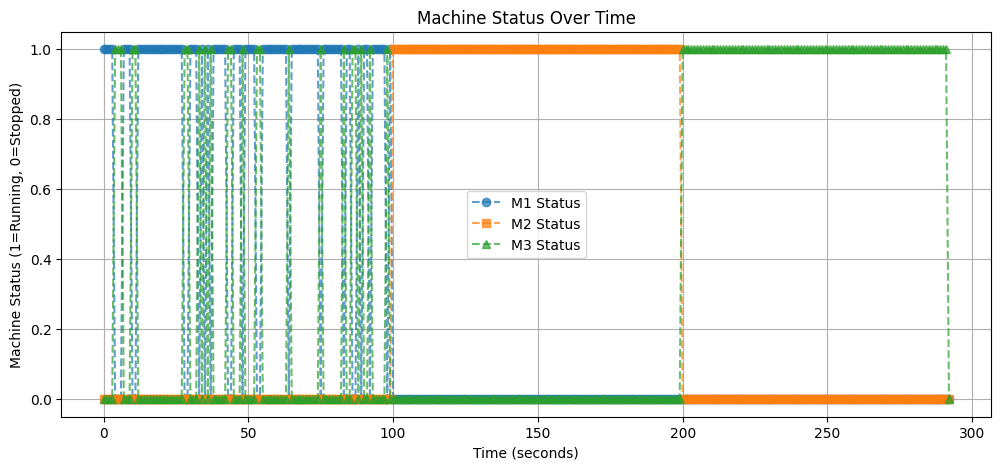

In [81]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.plot(df["Timestamps"], df["M1_Status"], label="M1 Status", linestyle='dashed', marker='o', alpha=0.7)
plt.plot(df["Timestamps"], df["M2_Status"], label="M2 Status", linestyle='dashed', marker='s', alpha=0.7)
plt.plot(df["Timestamps"], df["M3_Status"], label="M3 Status", linestyle='dashed', marker='^', alpha=0.7)


plt.xlabel("Time (seconds)")
plt.ylabel("Machine Status (1=Running, 0=Stopped)")
plt.title("Machine Status Over Time")
plt.legend()
plt.grid()


plt.show()


The plot makes sense because Task 1 saw many fluctuations between M1 and M3 while from the 100th second, there are no such fluctuations.

### Worker Count Distribution Across Machines

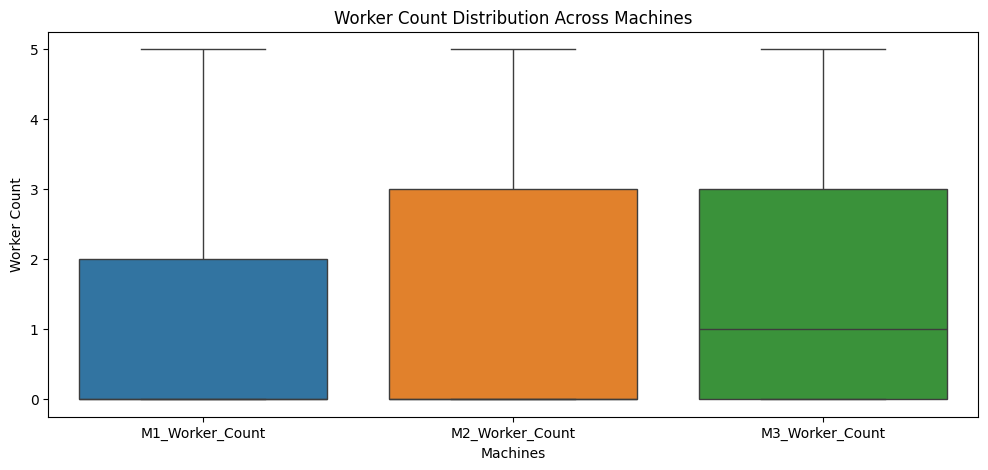

In [82]:
import seaborn as sns

# Boxplot to visualize worker count distribution
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[["M1_Worker_Count", "M2_Worker_Count", "M3_Worker_Count"]])


plt.title("Worker Count Distribution Across Machines")
plt.xlabel("Machines")
plt.ylabel("Worker Count")

plt.show()


The **box plot** suggests that:

1.  Worker counts range between 0 and 5.
2. The median for M1 is lower than for M2 and M3.
3. M3 has the widest range of worker counts



### Detecting Outliers in Worker Count

In [83]:
import numpy as np

# Compute Z-scores for worker count columns
worker_columns = ["M1_Worker_Count", "M2_Worker_Count", "M3_Worker_Count"]
z_scores = np.abs((df[worker_columns] - df[worker_columns].mean()) / df[worker_columns].std())

# Mark outliers where Z-score > 3
outliers = (z_scores > 3).any(axis=1)
df_outliers = df[outliers]

# Display outliers
if not df_outliers.empty:
    print("\n Detected Outliers in Worker Count:")
    print(df_outliers)
else:
    print("\n No significant outliers found in Worker Count.")



 No significant outliers found in Worker Count.


By using 3 as the Threshold value, only the extreme values are flagged.

### Identifying Stress Points (High Worker Loads)


 Stress Points Identified (High Worker Loads):
     Timestamps  M1_Status  M1_Worker_Count  M2_Status  M2_Worker_Count  \
0           0.0          1                4          0                0   
1           1.0          1                5          0                0   
6           6.0          0                0          0                0   
7           7.0          1                4          0                0   
8           8.0          1                3          0                2   
..          ...        ...              ...        ...              ...   
286       286.0          0                0          0                0   
287       287.0          0                0          0                0   
288       288.0          0                0          0                0   
289       289.0          0                0          0                0   
291       291.0          0                0          0                0   

     M3_Status  M3_Worker_Count  
0            0   

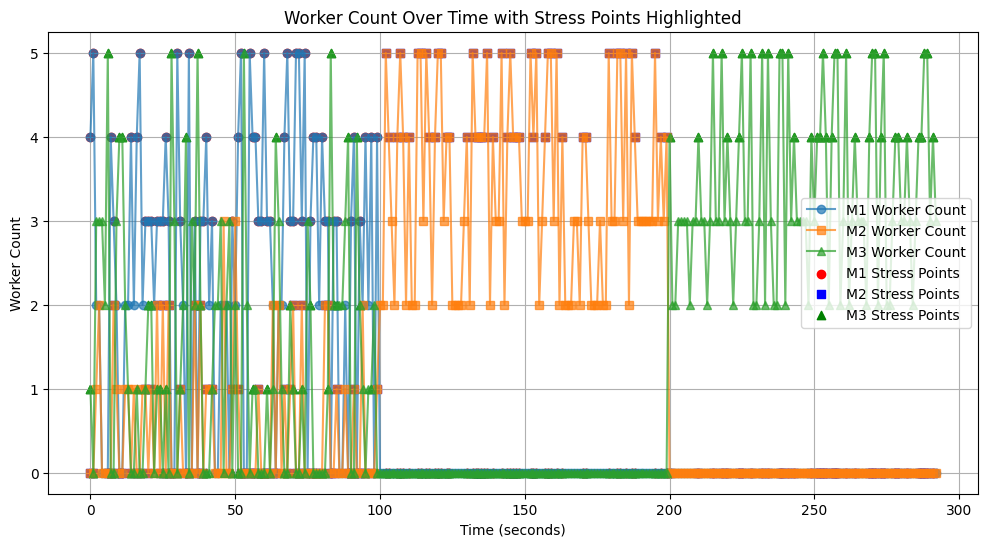

In [84]:
# Define stress threshold (Top 10% worker load)
stress_threshold = df[["M1_Worker_Count", "M2_Worker_Count", "M3_Worker_Count"]].quantile(0.9)

# Identify stress points where worker count exceeds the 90th percentile
stress_points = df[
    (df["M1_Worker_Count"] >= stress_threshold["M1_Worker_Count"]) |
    (df["M2_Worker_Count"] >= stress_threshold["M2_Worker_Count"]) |
    (df["M3_Worker_Count"] >= stress_threshold["M3_Worker_Count"])
]

#  Check for unusual cases where machines are running but have no workers
m1_no_workers = df[(df["M1_Status"] == 1) & (df["M1_Worker_Count"] == 0)]
m2_no_workers = df[(df["M2_Status"] == 1) & (df["M2_Worker_Count"] == 0)]
m3_no_workers = df[(df["M3_Status"] == 1) & (df["M3_Worker_Count"] == 0)]


if not stress_points.empty:
    print("\n Stress Points Identified (High Worker Loads):")
    print(stress_points)

    # Check for inefficiencies (machines running but no workers)
    if not m1_no_workers.empty:
        print("\n Inefficiency Detected: M1 Running with No Workers")
        print(m1_no_workers)
    if not m2_no_workers.empty:
        print("\n Inefficiency Detected: M2 Running with No Workers")
        print(m2_no_workers)
    if not m3_no_workers.empty:
        print("\n Inefficiency Detected: M3 Running with No Workers")
        print(m3_no_workers)

else:
    print("\n No significant stress points found.")

# Plotting Worker Count Over Time
plt.figure(figsize=(12, 6))

#  worker counts for each machine over time
plt.plot(df["Timestamps"], df["M1_Worker_Count"], label="M1 Worker Count", linestyle='-', marker='o', alpha=0.7)
plt.plot(df["Timestamps"], df["M2_Worker_Count"], label="M2 Worker Count", linestyle='-', marker='s', alpha=0.7)
plt.plot(df["Timestamps"], df["M3_Worker_Count"], label="M3 Worker Count", linestyle='-', marker='^', alpha=0.7)

#  stress points
plt.scatter(stress_points["Timestamps"], stress_points["M1_Worker_Count"], color='red', label="M1 Stress Points", marker='o')
plt.scatter(stress_points["Timestamps"], stress_points["M2_Worker_Count"], color='blue', label="M2 Stress Points", marker='s')
plt.scatter(stress_points["Timestamps"], stress_points["M3_Worker_Count"], color='green', label="M3 Stress Points", marker='^')


plt.xlabel("Time (seconds)")
plt.ylabel("Worker Count")
plt.title("Worker Count Over Time with Stress Points Highlighted")
plt.legend()
plt.grid()

plt.show()


The plot shows worker count variations over time for M1, M2, and M3, with stress points (top 10% worker loads) highlighted. M3 exhibits the highest worker fluctuations, while M2 maintains high worker loads for extended periods, suggesting possible bottlenecks or workload imbalances.

### Identifying Critical Points (Sudden Machine Status Changes)

In [85]:
# Compute change in machine status (1 = Change, 0 = No Change)
df["M1_Change"] = df["M1_Status"].diff().fillna(0).abs()
df["M2_Change"] = df["M2_Status"].diff().fillna(0).abs()
df["M3_Change"] = df["M3_Status"].diff().fillna(0).abs()

# Identify critical points (where machine status changes)
critical_points = df[
    (df["M1_Change"] == 1) | (df["M2_Change"] == 1) | (df["M3_Change"] == 1)
]

# critical points
if not critical_points.empty:
    print("\n Critical Points (Machine Status Changes):")
    print(critical_points)
else:
    print("\n No major critical points found.")



 Critical Points (Machine Status Changes):
     Timestamps  M1_Status  M1_Worker_Count  M2_Status  M2_Worker_Count  \
4           4.0          0                0          0                0   
7           7.0          1                4          0                0   
10         10.0          0                0          0                0   
12         12.0          1                2          0                1   
28         28.0          0                0          0                0   
30         30.0          1                5          0                0   
33         33.0          0                0          0                0   
34         34.0          1                5          0                0   
35         35.0          0                0          0                0   
36         36.0          1                3          0                2   
37         37.0          0                0          0                0   
38         38.0          1                3          0  

Frequent machine status changes occur primarily in the early stages (0-100s) and around 200th second

### Introducing Aritificial Anomaly

In [87]:
# To test the logic of the code

# Make Task 3 run beyond its expected end time
df.loc[df.index[-1], "M3_Status"] = 1  # To ensure M3 is running
df.loc[df.index[-1], "Timestamps"] = expected_task_times_sec["Task_3_End"] + 10  # 10 sec extra delay

print(" => Anomaly Introduced at the Last Index:")
print(df.iloc[-1])


 => Anomaly Introduced at the Last Index:
Timestamps         302.0
M1_Status            0.0
M1_Worker_Count      0.0
M2_Status            0.0
M2_Worker_Count      0.0
M3_Status            1.0
M3_Worker_Count      3.0
M1_Change            0.0
M2_Change            0.0
M3_Change            1.0
Name: 292, dtype: float64


### Anomaly Detection Logic

In [88]:
# Expected SOP times (in seconds from start)
expected_task_times_sec = {
    "Task_1_Start": 0,
    "Task_1_End": (datetime.strptime("17:59:47", "%H:%M:%S") - start_time).total_seconds(),
    "Task_2_Start": (datetime.strptime("17:59:47", "%H:%M:%S") - start_time).total_seconds(),
    "Task_2_End": (datetime.strptime("18:01:27", "%H:%M:%S") - start_time).total_seconds(),
    "Task_3_Start": (datetime.strptime("18:01:27", "%H:%M:%S") - start_time).total_seconds(),
    "Task_3_End": (datetime.strptime("18:02:59", "%H:%M:%S") - start_time).total_seconds(),
}

# Initialize transition & anomaly columns
df["Task_1_to_2_Transition"] = 0
df["Task_3_Flag"] = 0
df["Task_1_Anomaly"] = 0
df["Task_2_Anomaly"] = 0
df["Task_3_Anomaly"] = 0

# Track previous machine states & task times
previous_m1 = 0
previous_m2 = 0
previous_m3 = 0
task_start_times = {}
task_end_times = {}

# Process task transitions & anomaly detection together
for i in range(len(df)):
    timestamp = df.loc[i, "Timestamps"]
    m1_status = df.loc[i, "M1_Status"]
    m2_status = df.loc[i, "M2_Status"]
    m3_status = df.loc[i, "M3_Status"]

    #  Detect Task 1 to Task 2 Transition (Only if Task 2 Start Time is Reached)
    if (
        m2_status == 1 and m1_status == 0 and m3_status == 0
        and (previous_m1 == 1 or previous_m3 == 1)  # Ensures Task 1 was running before
        and timestamp >= expected_task_times_sec["Task_2_Start"]  # Ensures Task 2 should start
    ):
        df.loc[i, "Task_1_to_2_Transition"] = 1
        task_start_times["Task_2"] = timestamp
        task_end_times["Task_1"] = timestamp  # Task 1 ends

    #  Detect Task 3 Start (Only if Task 3 Start Time is Reached)
    if (
        m3_status == 1 and m1_status == 0 and m2_status == 0
        and previous_m2 == 1  # Ensures Task 2 was running before
        and timestamp >= expected_task_times_sec["Task_3_Start"]  # Ensures Task 3 should start
    ):
        df.loc[i, "Task_3_Flag"] = 1
        task_start_times["Task_3"] = timestamp
        task_end_times["Task_2"] = timestamp  # Task 2 ends

    #  Detect Anomalies in Real Time
    if "Task_1" in task_start_times and "Task_1" not in task_end_times:
        if timestamp > expected_task_times_sec["Task_1_End"]:
            df.loc[i, "Task_1_Anomaly"] = 1  # Task 1 running too long

    if "Task_2" in task_start_times and "Task_2" not in task_end_times:
        if timestamp > expected_task_times_sec["Task_2_End"]:
            df.loc[i, "Task_2_Anomaly"] = 1  # Task 2 running too long

    if "Task_3" in task_start_times:
        if timestamp > expected_task_times_sec["Task_3_End"]:
            df.loc[i, "Task_3_Anomaly"] = 1  # Task 3 running too long

    # Update previous machine states
    previous_m1, previous_m2, previous_m3 = m1_status, m2_status, m3_status

print("Task Transitions & Anomaly Detection Processed Successfully!")
print(df[["Timestamps", "Task_1_to_2_Transition", "Task_3_Flag", "Task_1_Anomaly", "Task_2_Anomaly", "Task_3_Anomaly"]].head())


Task Transitions & Anomaly Detection Processed Successfully!
   Timestamps  Task_1_to_2_Transition  Task_3_Flag  Task_1_Anomaly  \
0         0.0                       0            0               0   
1         1.0                       0            0               0   
2         2.0                       0            0               0   
3         3.0                       0            0               0   
4         4.0                       0            0               0   

   Task_2_Anomaly  Task_3_Anomaly  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  


In [104]:
df.columns


Index(['Timestamps', 'M1_Status', 'M1_Worker_Count', 'M2_Status',
       'M2_Worker_Count', 'M3_Status', 'M3_Worker_Count', 'M1_Change',
       'M2_Change', 'M3_Change', 'Task_1_to_2_Transition', 'Task_3_Flag',
       'Task_1_Anomaly', 'Task_2_Anomaly', 'Task_3_Anomaly'],
      dtype='object')

As seen above, we introduced 5 new columns into the dataset. These are the ***Task_1_to_2_Transition, Task_3_Flag, Task_1_Anomaly, Task_2_Anomaly, Task_3_Anomaly***, and help us to differentiate between tasks and anomalies. The columns M1_change, M2_change, and M3_change show the change in machine status and add no significant contribution to this code.


In [93]:
# Extract rows where transitions occur
task_1_to_2_transitions = df[df["Task_1_to_2_Transition"] == 1][["Timestamps"]]
task_3_transitions = df[df["Task_3_Flag"] == 1][["Timestamps"]]

# Print results
print(" => Task 1 to Task 2 Transitions:")
print(task_1_to_2_transitions.to_string(index=False))

print("\n => Task 2 to Task 3 Transitions:")
print(task_3_transitions.to_string(index=False))


 => Task 1 to Task 2 Transitions:
 Timestamps
      100.0

 => Task 2 to Task 3 Transitions:
 Timestamps
      200.0


The above timestamps indicate that task transitions are correctly identified

In [94]:
# Extract rows where anomalies are detected
task_1_anomalies = df[df["Task_1_Anomaly"] == 1][["Timestamps", "Task_1_Anomaly"]]
task_2_anomalies = df[df["Task_2_Anomaly"] == 1][["Timestamps", "Task_2_Anomaly"]]
task_3_anomalies = df[df["Task_3_Anomaly"] == 1][["Timestamps", "Task_3_Anomaly"]]

# Check if any anomalies exist
if task_1_anomalies.empty and task_2_anomalies.empty and task_3_anomalies.empty:
    print("*** No anomalies detected in the dataset. ***")
else:
    print(" => Anomalies Detected in the Dataset: ")

    if not task_1_anomalies.empty:
        print("\n Task 1 Anomalies:")
        print(task_1_anomalies.to_string(index=False))

    if not task_2_anomalies.empty:
        print("\n Task 2 Anomalies:")
        print(task_2_anomalies.to_string(index=False))

    if not task_3_anomalies.empty:
        print("\n Task 3 Anomalies:")
        print(task_3_anomalies.to_string(index=False))


 => Anomalies Detected in the Dataset: 

 Task 3 Anomalies:
 Timestamps  Task_3_Anomaly
      302.0               1


There is only one anomaly and that too was introduced at the last index. The logic we have written correctly identified the existing anomalies in the dataset.

# Graph Convolutional Neural Network

## Graph Construction

In [95]:
import torch
import networkx as nx
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Define Nodes (Machines)
nodes = ["M1", "M2", "M3"]
node_mapping = {node: i for i, node in enumerate(nodes)}

# Define Edges (Task Dependencies)
edges = [(node_mapping["M1"], node_mapping["M2"]),
         (node_mapping["M2"], node_mapping["M3"])]

# Convert edges into tensor format for GNN
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Extract Node Features
features = []
for i, row in df.iterrows():
    features.append([
        row["M1_Status"], row["M2_Status"], row["M3_Status"],  # Machine Running Status
        row["M1_Worker_Count"], row["M2_Worker_Count"], row["M3_Worker_Count"],  # Worker Count
        row["Task_1_to_2_Transition"], row["Task_3_Flag"]  # Transition Flags
    ])

features = torch.tensor(features, dtype=torch.float)

# Create Graph Data Object for GNN
graph_data = Data(x=features, edge_index=edge_index)

print("=> Graph Representation Created Successfully!")
print(graph_data)


=> Graph Representation Created Successfully!
Data(x=[293, 8], edge_index=[2, 2])


## Define GNN Model

In [96]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNAnomalyDetector(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNAnomalyDetector, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize Model
in_channels = features.shape[1]
hidden_channels = 16
out_channels = 1  # Binary Classification (Normal/Anomaly)

model = GNNAnomalyDetector(in_channels, hidden_channels, out_channels)
print("=> GNN Model Initialized")


=> GNN Model Initialized


## Train the GNN

In [97]:
import torch.optim as optim

# Define Loss and Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.BCEWithLogitsLoss()

# Train GNN
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(graph_data)

    # Use manually labeled anomalies for training
    labels = torch.tensor(df["Task_1_Anomaly"].values + df["Task_2_Anomaly"].values + df["Task_3_Anomaly"].values, dtype=torch.float).unsqueeze(1)

    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

print(" GNN Training Complete")


Epoch [0/500], Loss: 0.3081
Epoch [10/500], Loss: 0.0701
Epoch [20/500], Loss: 0.0317
Epoch [30/500], Loss: 0.0228
Epoch [40/500], Loss: 0.0209
Epoch [50/500], Loss: 0.0207
Epoch [60/500], Loss: 0.0205
Epoch [70/500], Loss: 0.0203
Epoch [80/500], Loss: 0.0201
Epoch [90/500], Loss: 0.0200
Epoch [100/500], Loss: 0.0200
Epoch [110/500], Loss: 0.0199
Epoch [120/500], Loss: 0.0198
Epoch [130/500], Loss: 0.0197
Epoch [140/500], Loss: 0.0197
Epoch [150/500], Loss: 0.0196
Epoch [160/500], Loss: 0.0196
Epoch [170/500], Loss: 0.0195
Epoch [180/500], Loss: 0.0195
Epoch [190/500], Loss: 0.0194
Epoch [200/500], Loss: 0.0194
Epoch [210/500], Loss: 0.0193
Epoch [220/500], Loss: 0.0193
Epoch [230/500], Loss: 0.0193
Epoch [240/500], Loss: 0.0192
Epoch [250/500], Loss: 0.0192
Epoch [260/500], Loss: 0.0192
Epoch [270/500], Loss: 0.0192
Epoch [280/500], Loss: 0.0191
Epoch [290/500], Loss: 0.0191
Epoch [300/500], Loss: 0.0190
Epoch [310/500], Loss: 0.0190
Epoch [320/500], Loss: 0.0189
Epoch [330/500], Loss

## Evaluating the Model against different hyperparameters

In [98]:
import itertools

# Defining hyperparameter grid
hidden_layer_sizes = [8, 16, 32]
learning_rates = [0.01, 0.001]
thresholds = [0.3, 0.4, 0.5]

# Generate all possible combinations
hyperparameter_combinations = list(itertools.product(hidden_layer_sizes, learning_rates, thresholds))

print(f"=> Testing {len(hyperparameter_combinations)} Hyperparameter Combinations")


=> Testing 18 Hyperparameter Combinations


### Define Model Training & Evaluation

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Function to train & evaluate model with given hyperparameters
def train_and_evaluate(hidden_dim, lr, threshold):
    # Define model
    model = GNNAnomalyDetector(in_channels, hidden_dim, out_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train model
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(graph_data)

        labels = torch.tensor(df["Task_1_Anomaly"].values + df["Task_2_Anomaly"].values + df["Task_3_Anomaly"].values, dtype=torch.float).unsqueeze(1)

        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

    # Evaluate model
    model.eval()
    predictions = model(graph_data).detach().numpy()
    predicted_labels = (predictions > threshold).astype(int)

    # Calculate evaluation metrics
    y_true = df["Task_1_Anomaly"].values + df["Task_2_Anomaly"].values + df["Task_3_Anomaly"].values
    precision = precision_score(y_true, predicted_labels, zero_division=1)
    recall = recall_score(y_true, predicted_labels, zero_division=1)
    f1 = f1_score(y_true, predicted_labels, zero_division=1)
    roc_auc = roc_auc_score(y_true, predictions)

    return {"Hidden Size": hidden_dim, "LR": lr, "Threshold": threshold,
            "Precision": precision, "Recall": recall, "F1-Score": f1, "ROC-AUC": roc_auc}


### Run Hyperparameter Search

In [100]:
import pandas as pd

# Store results
results = []

for hidden_dim, lr, threshold in hyperparameter_combinations:
    print(f"=> Evaluating: Hidden={hidden_dim}, LR={lr}, Threshold={threshold}")
    metrics = train_and_evaluate(hidden_dim, lr, threshold)
    results.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\n GNN Hyperparameter Evaluation Results:")
print(results_df)



=> Evaluating: Hidden=8, LR=0.01, Threshold=0.3
=> Evaluating: Hidden=8, LR=0.01, Threshold=0.4
=> Evaluating: Hidden=8, LR=0.01, Threshold=0.5
=> Evaluating: Hidden=8, LR=0.001, Threshold=0.3
=> Evaluating: Hidden=8, LR=0.001, Threshold=0.4
=> Evaluating: Hidden=8, LR=0.001, Threshold=0.5
=> Evaluating: Hidden=16, LR=0.01, Threshold=0.3
=> Evaluating: Hidden=16, LR=0.01, Threshold=0.4
=> Evaluating: Hidden=16, LR=0.01, Threshold=0.5
=> Evaluating: Hidden=16, LR=0.001, Threshold=0.3
=> Evaluating: Hidden=16, LR=0.001, Threshold=0.4
=> Evaluating: Hidden=16, LR=0.001, Threshold=0.5
=> Evaluating: Hidden=32, LR=0.01, Threshold=0.3
=> Evaluating: Hidden=32, LR=0.01, Threshold=0.4
=> Evaluating: Hidden=32, LR=0.01, Threshold=0.5
=> Evaluating: Hidden=32, LR=0.001, Threshold=0.3
=> Evaluating: Hidden=32, LR=0.001, Threshold=0.4
=> Evaluating: Hidden=32, LR=0.001, Threshold=0.5

 GNN Hyperparameter Evaluation Results:
    Hidden Size     LR  Threshold  Precision  Recall  F1-Score   ROC-AUC
0

In [101]:
print(results_df.describe())


       Hidden Size        LR  Threshold  Precision  Recall  F1-Score  \
count    18.000000  18.00000  18.000000  18.000000    18.0      18.0   
mean     18.666667   0.00550   0.400000   0.833333     0.0       0.0   
std      10.267023   0.00463   0.084017   0.383482     0.0       0.0   
min       8.000000   0.00100   0.300000   0.000000     0.0       0.0   
25%       8.000000   0.00100   0.300000   1.000000     0.0       0.0   
50%      16.000000   0.00550   0.400000   1.000000     0.0       0.0   
75%      32.000000   0.01000   0.500000   1.000000     0.0       0.0   
max      32.000000   0.01000   0.500000   1.000000     0.0       0.0   

         ROC-AUC  
count  18.000000  
mean    0.653539  
std     0.198648  
min     0.232877  
25%     0.589041  
50%     0.714041  
75%     0.798801  
max     0.900685  


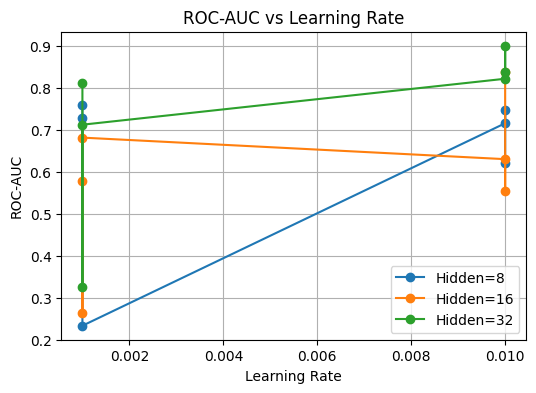


Best Hyperparameter Set Based on ROC-AUC:
Hidden Size    32.000000
LR              0.010000
Threshold       0.400000
Precision       1.000000
Recall          0.000000
F1-Score        0.000000
ROC-AUC         0.900685
Name: 13, dtype: float64


In [102]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(6, 4))

# Plot ROC-AUC for different Hidden Sizes
for hidden_size in results_df["Hidden Size"].unique():
    subset = results_df[results_df["Hidden Size"] == hidden_size]
    plt.plot(subset["LR"], subset["ROC-AUC"], marker='o', linestyle='-', label=f'Hidden={hidden_size}')

# Labels and title
plt.xlabel("Learning Rate")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs Learning Rate")
plt.legend()
plt.grid()

# Show plot
plt.show()

# Identify the best hyperparameter set based on ROC-AUC
best_hyperparams = results_df.sort_values(by="ROC-AUC", ascending=False).iloc[0]

print("\nBest Hyperparameter Set Based on ROC-AUC:")
print(best_hyperparams)
